This notebook looks for correlations in income mobility and public (K-12) education spending. It uses income mobility data for people born in 1978-1983, and education spending data in a representative year for those subjects (1995). 

**Motivation**: 

Income mobility is the ability of an individual or family to improve (or lower) their economic status. The American Dream is that anyone, regardless of where they were born or what class they were born into, can attain their own version of success in a society where upward mobility is possible for everyone. Economic mobility is the bedrock of the American Dream. 

It is well understood that overall economic mobility in the US has declined over the past century. The American public expects that public education spending supports income mobility. This notebook studies variations in income mobility on the basis of race, gender, and zip code, and looks for correlations between income mobility and education funding.

**Goal**:

The goal of this study is to identify trends in education spending that correlate most strongly with a level playing field for all students. For example, the notebook identifies correlations between income mobility and per-pupil spending on particular education resources for zip codes throughout the US. It further explores differences in those correlations for students depending on their race and gender. 

It is a given that income mobility depends on more than public education, and that K-12 education financing will itself correlate with factors that impact mobility beyond education expenses (eg, policing policy and neighborhood wealth). The differences in the correlation between student outcomes and education spending for students in the same zip code but different races and genders are the most telling aspects of this data. 

**Preliminary Observations**

Preliminary analysis shows a positive overall correlation between income mobility and education spending. That is, zip codes that spent more per pupil on education also saw a higher liklihood of income mobility. (That's great, it's the desired impact of a public education system.) 

The likelihood of income mobility varies across race and gender. White male students have a higher baseline probability of upward income mobility and have a stronger positive correlation with nearly all aspects of education spending. That is, their liklihood of mobility increases more than any other group for every education dollar spent. Many of the other demographics do not show any meaningful positive correlation with education spending. Education spending doesn't correlate with their success. 

A future aim is to identify types of spending that could have larger positive impact on POC and female students. The ideal is for all students to show the same benefit from education dollars that we currently observe in white students. This type of analysis may find application in education policy. 



**Data Sources**: 

Opportunity Insights provides income mobility analysis data:
>[Income mobility by commuting zone](
https://opportunityinsights.org/data/?geographic_level=0&topic=0&paper_id=0#resource-listing) for children born in years 1978-1983, based on census in 2000

>[Explanation of dataset](https://opportunityinsights.org/wp-content/uploads/2018/04/table_4.pdf)

>[Paper on Income Mobility by race and gender](https://opportunityinsights.org/wp-content/uploads/2018/04/race_paper.pdf)


US Census data:
> [Individual unit tables, 1995](https://www.census.gov/data/tables/1995/econ/school-finances/secondary-education-finance.html)

**Future Study**
It would be interesting to look at how student performance correlates with mobility. [This Kaggle dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project?select=states_all.csv) merges student performance data with education spending data at the state level.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import geopandas as gpd
from mpl_toolkits.axes_grid1 import ImageGrid
import us
from shapely.geometry import Point, Polygon
import statsmodels.api as sm

# Social Mobility Data

In [2]:
file_name = "ProjectData/table_4.csv"
df = pd.read_csv(file_name)
print(df.keys())

Index(['cz', 'cz_name', 'cz_pop2000', 'cz_pop_black2000', 'cz_pop_hisp2000',
       'cz_pop_white2000', 'kfr_pooled_p25', 'kfr_black_pooled_p25',
       'kfr_white_pooled_p25', 'kir_black_female_p25', 'kir_black_female_p75',
       'kir_black_male_p25', 'kir_black_male_p75', 'kir_hisp_female_p25',
       'kir_hisp_female_p75', 'kir_hisp_male_p25', 'kir_hisp_male_p75',
       'kir_white_female_p25', 'kir_white_female_p75', 'kir_white_male_p25',
       'kir_white_male_p75'],
      dtype='object')


#### Explanation of vars 
(kfr and kir: Kid Family Rank, and Kid Individual Rank):

kfr_pooled_p25: Mean kid household income rank for a child with parents at the 25th percentile rank of the national income distribution (pooled across race and gender)

kfr_[race]_pooled_p[pctile]: Mean kid household income rank for children (pooled across gender) with
    - [race] black or white
    - born to parents in the [pctile] 25th 
    
kir_[race]_[gender]_p[pctile]: Mean kid individual income rank in the CZ for a child with
    - [race] black, white, or Hispanic
    - [gender] male, female, or pooled
    - born to parents in the [pctile] 25th or 75th percentile of the national distribution for parents of children in the same cohort

In [11]:
## Commuting zone -> State and County (FIPS) to compare to Eduction spending

# https://www.ers.usda.gov/data-products/commuting-zones-and-labor-market-areas/

czfile = 'ProjectData/cz_to_fips.xls'
cdf = pd.read_excel(czfile)

# merge on commuting zone id, 1990 
cdf['cz'] = cdf['Commuting Zone ID, 1990']
mobilitydf = pd.merge(df, cdf, on='cz')
# now we have cz-level social mobility data repeated for every county that is in the cz

# Separate State and County FIPDS
mobilitydf['FIPS_s'] = [str(num)[:-3] for num in mobilitydf.FIPS]
mobilitydf['FIPS_c'] = [str(num)[-3:] for num in mobilitydf.FIPS]

mobilitydf.FIPS= mobilitydf.FIPS.astype(int)
mobilitydf['FIPS_s'] = mobilitydf['FIPS_s'].astype(int)
mobilitydf['FIPS_c'] = mobilitydf['FIPS_c'].astype(int)

countymob = mobilitydf.groupby('FIPS').mean()

### Look at California

In [24]:
# Start with CA counties
CAdf = countymob[countymob['FIPS_s']==6]

# get dataframe of county shapes
CAshapes = gpd.read_file(us.states.CA.shapefile_urls('county'))
CAshapes['FIPS'] = (CAshapes.STATEFP10+CAshapes.COUNTYFP10).astype(int)
new_df = pd.merge(CAshapes[['FIPS','geometry']], 
                  CAdf, 
                  how='left',
                  left_on='FIPS',
                  right_index=True, 
                  ) 

  

In [184]:
# all US county shapes
frames = []
for state in us.states.STATES:
    frames.append(gpd.read_file(state.shapefile_urls('county')))
USshapes = pd.concat(frames)

In [185]:
USshapes['FIPS'] = (USshapes.STATEFP10+USshapes.COUNTYFP10).astype(int)

In [204]:
contiguous_mask = (USshapes.STATEFP10!=us.states.HI.fips) & (USshapes.STATEFP10!=us.states.AK.fips)
USshapes=USshapes.loc[contiguous_mask]

In [205]:
new_df = pd.merge(USshapes[['FIPS','geometry']], 
                  countymob, 
                  how='left',
                  left_on='FIPS',
                  right_index=True, 
                  ) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


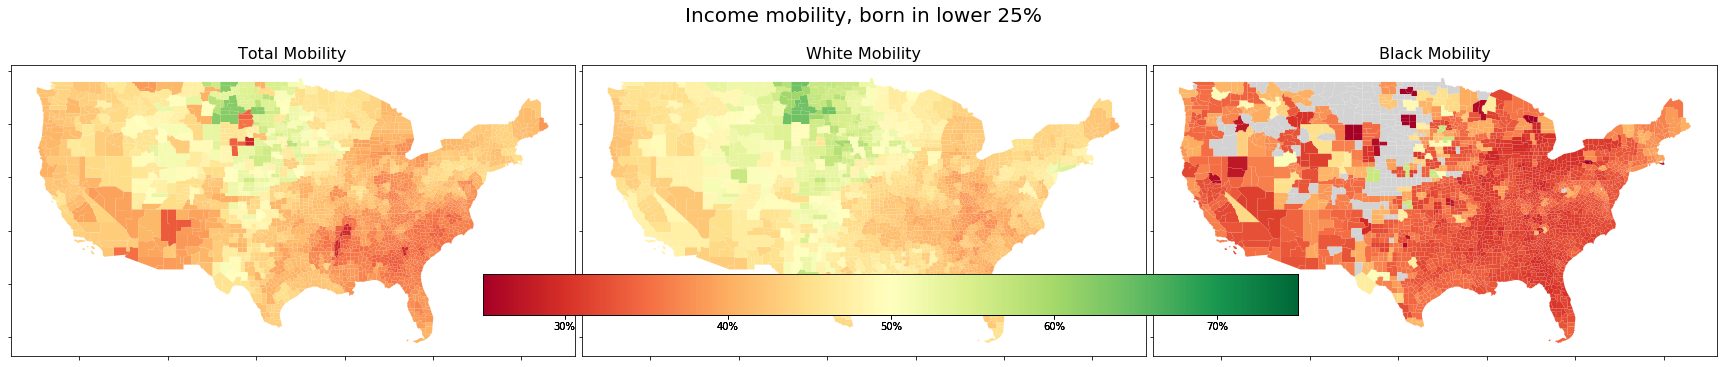

In [239]:
toplot = ['kfr_pooled_p25', 'kfr_white_pooled_p25', 'kfr_black_pooled_p25']

title= 'Income mobility, born in lower 25%'
stitles = ['Total Mobility','White Mobility','Black Mobility' ]

fig = plt.figure(figsize=(30, 5))

grid = ImageGrid(fig, 111,        
                 nrows_ncols=(1,3),
                 axes_pad=0.1
                 )

for i, axis in enumerate(grid):
    
    new_df.plot(column=toplot[i], 
                ax=axis, 
                missing_kwds={'color': 'lightgrey'}, 
                vmin = 25,
                vmax = 75,
                cmap='RdYlGn',
                legend=True,
                legend_kwds={'orientation': "horizontal", 'format': '%.0f%%', "pad":500,"shrink": .7}
               )
    axis.tick_params(labelleft=False, labelbottom=False)  
    axis.set_title(stitles[i], fontsize=16)
    axis.set_aspect(1.2)

    
fig.suptitle(title, fontsize=20);
fig.tight_layout(rect=[0, -0.03, 1, 0.9])

# Education data

In [30]:
# This is just the data from 1995.
edufile = 'ProjectData/EducationSpending/census/elsec95t.xls'
df2 = pd.read_excel(edufile)
df2.describe()

,GOVSID,FIPS,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,FEDRHAND,FEDRNUTR,FEDROTHR,TSTREV,...,PPSALWG,PPEMPBEN,PPITOTAL,PPISALWG,PPIEMBEN,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,PPSSCHAD
count,1.555300e+04,1.555300e+04,1.555300e+04,1.555300e+04,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000,1.555300e+04,...,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000,15553.000000
mean,2.738396e+13,1.287621e+10,2.816667e+03,1.795652e+04,1162.810776,410.185366,133.606442,318.888382,300.130586,8.378262e+03,...,3401.334019,747.826464,3278.285283,2377.855140,501.760368,1795.189545,178.787629,154.563814,234.310037,248.975503
std,1.356253e+13,1.737715e+10,1.297051e+04,9.031788e+04,9281.642878,4198.629673,661.634491,2513.663781,2455.345097,4.209069e+04,...,1615.277817,474.435894,1549.150470,1113.590336,330.485753,1052.433285,181.703031,149.072450,267.817149,178.582517
min,1.500100e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.650210e+13,3.000100e+04,2.560000e+02,2.049000e+03,86.000000,25.000000,0.000000,15.000000,7.000000,7.650000e+02,...,2750.000000,439.000000,2617.000000,1917.000000,287.000000,1327.000000,65.000000,74.000000,94.000000,169.000000
50%,2.850018e+13,5.000500e+04,8.930000e+02,5.873000e+03,253.000000,85.000000,13.000000,62.000000,31.000000,2.576000e+03,...,3216.000000,714.000000,3100.000000,2249.000000,478.000000,1650.000000,145.000000,136.000000,173.000000,254.000000
75%,3.750620e+13,2.616322e+10,2.412000e+03,1.533900e+04,747.000000,249.000000,99.000000,188.000000,151.000000,6.916000e+03,...,3911.000000,996.000000,3843.000000,2746.000000,670.000000,2106.000000,240.000000,209.000000,295.000000,327.000000
max,5.150230e+13,5.602514e+10,1.022534e+06,8.025686e+06,846971.000000,429093.000000,41936.000000,202601.000000,173341.000000,3.275295e+06,...,24510.000000,7345.000000,27000.000000,18000.000000,6000.000000,20347.000000,3158.000000,4956.000000,6593.000000,2690.000000


In [31]:
# Some of these FIPS reported also include 6 digit census track at tail
# Strip census track information, where reported
mask = (df2.FIPS>100000)
df2 = df2.loc[mask]
df2.FIPS = df2.FIPS.floordiv(1000000)

In [32]:
# Drop rows with FIPS shorter than 4 digits (What do those mean?)
mask = (df2.FIPS>=1000)
df2 = df2.loc[mask]
df2['FIPS_c'] = [int(str(num)[-3:]) for num in df2.FIPS]
df2['FIPS_s'] = [int(str(num)[-5:-3]) for num in df2.FIPS]
countyedu = df2.groupby('FIPS').mean()
# about 7k schools in 841 counties

In [245]:
countyedu.describe()

,GOVSID,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,FEDRHAND,FEDRNUTR,FEDROTHR,TSTREV,STRFORM,...,PPITOTAL,PPISALWG,PPIEMBEN,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,PPSSCHAD,FIPS_c,FIPS_s
count,8.410000e+02,8.410000e+02,8.410000e+02,841.000000,841.000000,841.000000,841.000000,841.000000,8.410000e+02,8.410000e+02,...,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000
mean,2.804511e+13,1.225791e+04,7.503387e+04,5294.072413,1917.183558,588.842955,1584.858863,1203.187037,3.485368e+04,2.369232e+04,...,3035.493261,2241.048319,492.355129,1669.353181,194.277544,186.262028,149.784524,262.083912,106.120095,30.611177
std,1.459698e+13,4.156750e+04,3.105398e+05,30931.988671,15280.834601,1810.108263,7770.429211,6466.994800,1.314675e+05,1.013038e+05,...,863.141668,643.540258,235.074958,553.960090,111.235671,102.457832,107.838242,91.763437,131.148003,15.530456
min,1.500100e+12,0.000000e+00,1.411500e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.550180e+13,2.071091e+03,1.249450e+04,582.500000,190.500000,87.679487,147.500000,107.545455,6.049667e+03,4.075667e+03,...,2558.280000,1876.000000,337.833333,1336.000000,126.000000,122.000000,73.000000,207.625000,29.000000,18.000000
50%,3.047453e+13,3.923800e+03,2.421917e+04,1380.000000,430.000000,194.800000,364.137931,273.000000,1.127624e+04,8.086056e+03,...,2860.000000,2135.200000,505.461538,1560.166667,174.800000,169.266667,126.000000,258.200000,73.000000,33.000000
75%,4.150230e+13,9.185000e+03,5.104300e+04,3323.500000,1025.583333,442.600000,1008.000000,814.000000,2.717281e+04,1.920700e+04,...,3290.200000,2418.250000,610.000000,1877.538462,240.000000,230.625000,202.500000,311.000000,125.000000,45.000000
max,5.150130e+13,1.022534e+06,8.025686e+06,846971.000000,429093.000000,41936.000000,202601.000000,173341.000000,3.275295e+06,2.719291e+06,...,7745.422535,5797.563380,1566.014085,4197.647887,848.000000,1266.000000,790.500000,926.000000,830.000000,56.000000


In [104]:
count_nan2 = len(df2) - df2.count()
count_nan2

GOVSID      0
FIPS        0
NAME        0
ENROLL      0
TOTALREV    0
           ..
PPSSTAFF    0
PPSGENAD    0
PPSSCHAD    0
FIPS_c      0
FIPS_s      0
Length: 65, dtype: int64

Description of vars 
    https://www.census.gov/programs-surveys/school-finances/technical-documentation/complete/2018.html
    
'GOVSID', 'FIPS', 'NAME',

'ENROLL' : how many students were enrolled

'TOTALREV': total revenue
    'TFEDREV': total fed revenue (breaks down eg, fedrnutr: nutritional)
    'TSTREV': total state revenue (also breaks down eg strtrans: transportation)
    'TLOCREV': total local revenue ('LOCRTAX', 'LOCRPROP', 'LOCRPAR',
    'LOCRCICO', 'LOCROSCH', 'LOCRCHAR', 'LOCROTHR': all taxes, property taxes, parent contributions, revenue from cities+counties, revenue from other schools, charges, other

'TOTALEXP': total expenses
'TCURELSC': total current spending
       'TSALWAGE', 'TEMPBENE': salaries and emp benefits
'TCURINST': total current spending for instruction
       'TCURISAL', 'TCURIBEN': salaries and emp benefits for instruction 
'TCURSSVC': total current spending for support (breaks down)   
'TCAPOUT' : total capital outlay expenditure
'TPAYOTH', 'TINTRST', 'DEBTOUT', 'LONGISSU', 'LONGRET',: debt related

PCTTOTAL: PERCENT - TOTAL ELEMENTARY-SECONDARY REVENUE
    PCTFTOT: Percent - Total Revenue from Federal Sources
    PCTFCOMP: Percent - Compensatory (Title I)
    PCTSTOT: Percent - Total Revenue from State Sources
    PCTSFORM: Percent - General formula assistance
    PCTLTOT: Percent - Total Revenue from Local Sources
    PCTLTAXP: Percent - Taxes and parent government contributions
    PCTLOTHG: Percent - Revenue from other local governments
    PCTLCHAR: Percent - Charges

PPCSTOT: PER PUPIL - TOTAL CURRENT SPENDING (ELEMENTARY-SECONDARY)
    PPSALWG: Per Pupil - Total salaries and wages
    PPEMPBEN: Per Pupil - Total employee benefit payments
PPITOTAL: Per Pupil - Total Current Spending for Instruction
    PPISALWG: Per Pupil - Salaries and wages
    PPIEMBEN: Per Pupil - Employee benefits
PPSTOTAL: Per Pupil - Total Current Spending for Support Services
    PPSPUPIL: Per Pupil - Pupil support
    PPSSTAFF: Per Pupil - Instructional staff support
    PPSGENAD: Per Pupil - General administration
    PPSSCHAD: Per Pupil - School administration

## Look at California again

In [44]:
# Start with CA counties
CAeddf = countyedu[countyedu['FIPS_s']==6]
newEd_df = pd.merge(CAshapes[['FIPS','geometry']], 
                    CAeddf, 
                    how='left',
                    left_on='FIPS',
                    right_index=True
                    ) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


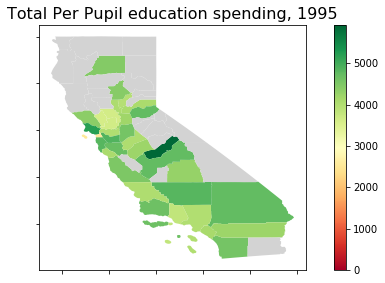

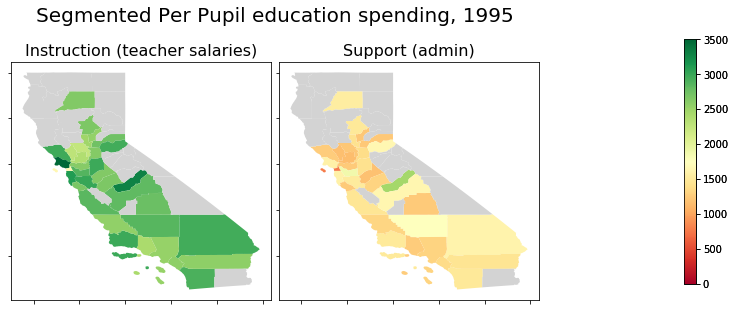

In [45]:
fig, ax = plt.subplots(figsize=(10, 4.5))
newEd_df.plot(column= 'PPCSTOT',
              ax=ax,
              missing_kwds={'color': 'lightgrey'}, 
                vmin = 0,
#                 vmax = 180000,
                cmap='RdYlGn',
              legend=True,
              legend_kwds={'orientation': "vertical"}
             )
               
ax.tick_params(labelleft=False, labelbottom=False);
ax.set_title('Total Per Pupil education spending, 1995', fontsize=16);


toplot = ['PPITOTAL', 'PPSTOTAL']

title= 'Segmented Per Pupil education spending, 1995'
stitles = ['Instruction (teacher salaries)', 'Support (admin)' ]

fig = plt.figure(figsize=(20, 4.5))

grid = ImageGrid(fig, 111,        
                 nrows_ncols=(1,2),
                 axes_pad=0.1
                 )

for i, axis in enumerate(grid):
    
    newEd_df.plot(column=toplot[i], 
                ax=axis, 
                missing_kwds={'color': 'lightgrey'}, 
                vmin = 0,
                vmax = 3500,
                cmap='RdYlGn',
                legend=True,
                legend_kwds={'orientation': "vertical", 'pad': 2}
               )
    axis.tick_params(labelleft=False, labelbottom=False)  
    axis.set_title(stitles[i], fontsize=16)
    
fig.suptitle(title, fontsize=20);
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

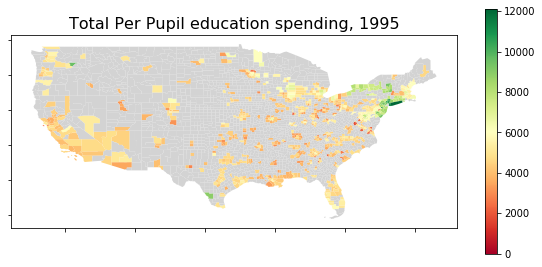

In [240]:
USnewEd_df = pd.merge(USshapes[['FIPS','geometry']], 
                    countyedu, 
                    how='left',
                    left_on='FIPS',
                    right_index=True
                    ) 

fig, ax = plt.subplots(figsize=(10, 4.5))
USnewEd_df.plot(column= 'PPCSTOT',
              ax=ax,
              missing_kwds={'color': 'lightgrey'}, 
                vmin = 0,
#                 vmax = 180000,
                cmap='RdYlGn',
              legend=True,
              legend_kwds={'orientation': "vertical"}
             )
               
ax.tick_params(labelleft=False, labelbottom=False);
ax.set_title('Total Per Pupil education spending, 1995', fontsize=16);



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


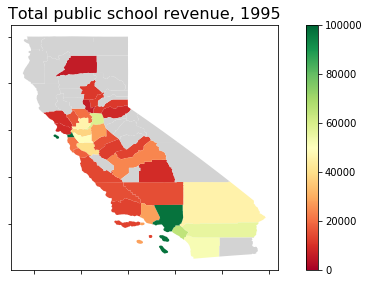

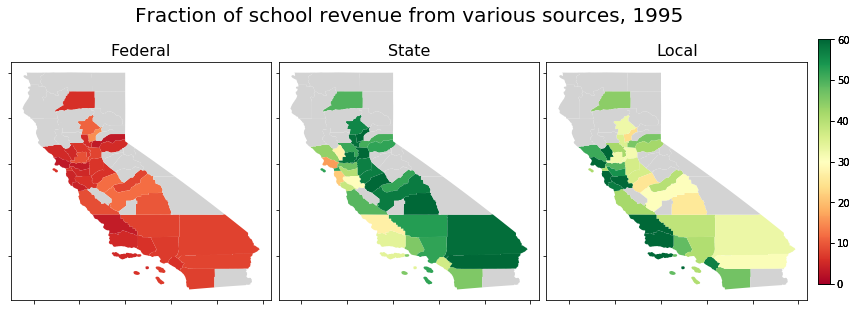

In [46]:
fig, ax = plt.subplots(figsize=(10, 4.5))
newEd_df.plot(column= 'TOTALREV',
              ax=ax,
              missing_kwds={'color': 'lightgrey'}, 
                vmin = 0,
                vmax = 100000,
                cmap='RdYlGn',
              legend=True,
              legend_kwds={'orientation': "vertical"}
             )
               
ax.tick_params(labelleft=False, labelbottom=False);
ax.set_title('Total public school revenue, 1995', fontsize=16);



toplot = ['PCTFTOT', 'PCTSTOT', 'PCTLTOT']

title= 'Fraction of school revenue from various sources, 1995'
stitles = ['Federal', 'State', 'Local' ]

fig = plt.figure(figsize=(20, 4.5))

grid = ImageGrid(fig, 111,        
                 nrows_ncols=(1,3),
                 axes_pad=0.1
                 )

for i, axis in enumerate(grid):
    
    newEd_df.plot(column=toplot[i], 
                ax=axis, 
                missing_kwds={'color': 'lightgrey'}, 
                vmin = 0,
                vmax = 60,
                cmap='RdYlGn',
                legend=True,
                legend_kwds={'orientation': "vertical", 'pad': 2}
               )
    axis.tick_params(labelleft=False, labelbottom=False)  
    axis.set_title(stitles[i], fontsize=16)
    
fig.suptitle(title, fontsize=20);
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

## Merge Income Mobility and Education Finance Data

In [56]:
'''
This table includes ave income mobility for people born 1978-1983, based on a census in 2000
As well as ave available education funding data for 1995 (when subjects were aged 12-17).
No education funding data was found prior to that time. 

'''

ddf = pd.merge(countymob, countyedu, left_index=True, right_index=True)
ddf.keys()

Index(['cz', 'cz_pop2000', 'cz_pop_black2000', 'cz_pop_hisp2000',
       'cz_pop_white2000', 'kfr_pooled_p25', 'kfr_black_pooled_p25',
       'kfr_white_pooled_p25', 'kir_black_female_p25', 'kir_black_female_p75',
       'kir_black_male_p25', 'kir_black_male_p75', 'kir_hisp_female_p25',
       'kir_hisp_female_p75', 'kir_hisp_male_p25', 'kir_hisp_male_p75',
       'kir_white_female_p25', 'kir_white_female_p75', 'kir_white_male_p25',
       'kir_white_male_p75', 'Commuting Zone ID, 2000',
       'Commuting Zone ID, 1990', 'Commuting Zone ID, 1980',
       'County Population 2000', 'Commuting Zone Population 2000', 'FIPS_s_x',
       'FIPS_c_x', 'GOVSID', 'ENROLL', 'TOTALREV', 'TFEDREV', 'FEDRCOMP',
       'FEDRHAND', 'FEDRNUTR', 'FEDROTHR', 'TSTREV', 'STRFORM', 'STRHAND',
       'STRTRANS', 'STROTHR', 'TLOCREV', 'LOCRTAX', 'LOCRPROP', 'LOCRPAR',
       'LOCRCICO', 'LOCROSCH', 'LOCRCHAR', 'LOCROTHR', 'TOTALEXP', 'TCURELSC',
       'TSALWAGE', 'TEMPBENE', 'TCURINST', 'TCURISAL', 'TCURIBEN

In [57]:
# some cols are repetitions 
cols_to_drop = ['Commuting Zone ID, 2000', 'Commuting Zone ID, 1990', 'Commuting Zone ID, 1980',
                'Commuting Zone Population 2000',
                'GOVSID',
                'FIPS_s_y', 'FIPS_c_y']

ddf.drop(cols_to_drop, axis=1, inplace=True) 
ddf.keys()

Index(['cz', 'cz_pop2000', 'cz_pop_black2000', 'cz_pop_hisp2000',
       'cz_pop_white2000', 'kfr_pooled_p25', 'kfr_black_pooled_p25',
       'kfr_white_pooled_p25', 'kir_black_female_p25', 'kir_black_female_p75',
       'kir_black_male_p25', 'kir_black_male_p75', 'kir_hisp_female_p25',
       'kir_hisp_female_p75', 'kir_hisp_male_p25', 'kir_hisp_male_p75',
       'kir_white_female_p25', 'kir_white_female_p75', 'kir_white_male_p25',
       'kir_white_male_p75', 'County Population 2000', 'FIPS_s_x', 'FIPS_c_x',
       'ENROLL', 'TOTALREV', 'TFEDREV', 'FEDRCOMP', 'FEDRHAND', 'FEDRNUTR',
       'FEDROTHR', 'TSTREV', 'STRFORM', 'STRHAND', 'STRTRANS', 'STROTHR',
       'TLOCREV', 'LOCRTAX', 'LOCRPROP', 'LOCRPAR', 'LOCRCICO', 'LOCROSCH',
       'LOCRCHAR', 'LOCROTHR', 'TOTALEXP', 'TCURELSC', 'TSALWAGE', 'TEMPBENE',
       'TCURINST', 'TCURISAL', 'TCURIBEN', 'TCURSSVC', 'TCURSPUP', 'TCURSSTA',
       'TCURSGEN', 'TCURSSCH', 'TCURSOTH', 'TCURONON', 'TCAPOUT', 'TPAYOTH',
       'TINTRST', 'DEBT

In [117]:
# there's a very small number of null rows, so let's just delete them.

# ddf.isnull().sum()[5:25]
ddf = ddf.dropna()

# Quick Analysis: Look for correlations

Look for correlations between spending and income mobility
    eg, 
        fraction of total revenue that comes from fed, state, local
        fraction of total expenses spent on instruction, support, other, capital_outlay
        correlating with 
        income mobility by race (kir_race_pooled_p25 or 75)


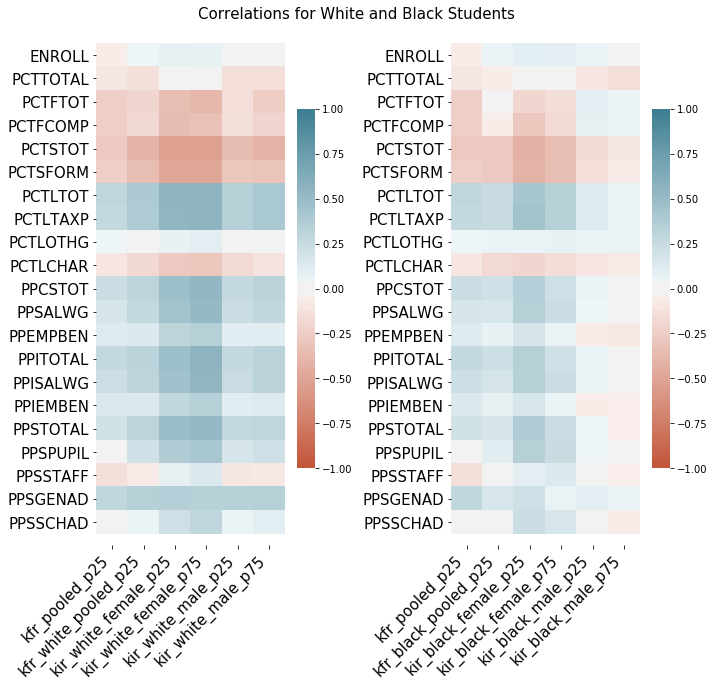

In [118]:
result=ddf.copy()

corr = result[['kfr_pooled_p25', 'kfr_white_pooled_p25', 
               'kir_white_female_p25', 'kir_white_female_p75', 
               'kir_white_male_p25', 'kir_white_male_p75',
               'ENROLL', 'PCTTOTAL',
               'PCTFTOT', 'PCTFCOMP', 'PCTSTOT', 'PCTSFORM', 'PCTLTOT', 'PCTLTAXP',
               'PCTLOTHG', 'PCTLCHAR', 'PPCSTOT', 'PPSALWG', 'PPEMPBEN', 'PPITOTAL',
               'PPISALWG', 'PPIEMBEN', 'PPSTOTAL', 'PPSPUPIL', 'PPSSTAFF', 'PPSGENAD',
               'PPSSCHAD']].corr()[['kfr_pooled_p25', 'kfr_white_pooled_p25', 
                                    'kir_white_female_p25', 'kir_white_female_p75', 
                                    'kir_white_male_p25', 'kir_white_male_p75']]

corr2 = result[['kfr_pooled_p25', 'kfr_black_pooled_p25', 
               'kir_black_female_p25', 'kir_black_female_p75', 
               'kir_black_male_p25', 'kir_black_male_p75',
               'ENROLL', 'PCTTOTAL',
               'PCTFTOT', 'PCTFCOMP', 'PCTSTOT', 'PCTSFORM', 'PCTLTOT', 'PCTLTAXP',
               'PCTLOTHG', 'PCTLCHAR', 'PPCSTOT', 'PPSALWG', 'PPEMPBEN', 'PPITOTAL',
               'PPISALWG', 'PPIEMBEN', 'PPSTOTAL', 'PPSPUPIL', 'PPSSTAFF', 'PPSGENAD',
               'PPSSCHAD']].corr()[['kfr_pooled_p25', 'kfr_black_pooled_p25', 
                                   'kir_black_female_p25', 'kir_black_female_p75', 
                                   'kir_black_male_p25', 'kir_black_male_p75']]



# fig, (ax,ax2) = plt.subplots(figsize=(22,22))
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2,nrows=1)
sns.heatmap(
    corr.tail(21), 
    ax=ax1,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    cbar=True,
    cbar_kws={"shrink": .7}
)
sns.heatmap(
    corr2.tail(21), 
    ax=ax2,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
#     cbar=True,
    cbar_kws={"shrink": .7}
)

for ax in (ax1, ax2):
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=15
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize = 15);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    

fig.suptitle('Correlations for White and Black Students',
            fontsize=15);
fig.tight_layout(rect=[0, 0.03, 1, .96])

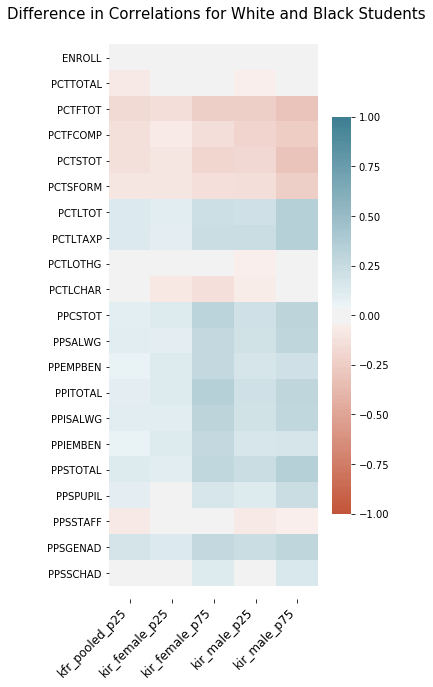

In [119]:
fig, ax = plt.subplots(figsize=(5,10))

t = pd.DataFrame(corr-corr2.values)
t.drop('kfr_pooled_p25', axis=1, inplace=True) 
t.columns = ['kfr_pooled_p25', 
             'kir_female_p25', 'kir_female_p75',
             'kir_male_p25', 'kir_male_p75']
sns.heatmap(
    t.tail(21),
    ax=ax,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
#     cbar=True,
    cbar_kws={"shrink": .7}
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize = 10);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.suptitle('Difference in Correlations for White and Black Students',
            fontsize=15);
fig.tight_layout(rect=[0, 0.03, 1, .96])

In [120]:
# these are the vars that will most strongly predict differences between white and black mobility

#     PCTFTOT: Percent - Total Revenue from Federal Sources
#     PCTSTOT: Percent - Total Revenue from State Sources
#     PCTLTOT: Percent - Total Revenue from Local Sources
#     (PCTLTAXP: Percent - Taxes and parent government contributions)

# PPCSTOT: PER PUPIL - TOTAL CURRENT SPENDING (ELEMENTARY-SECONDARY)
# PPITOTAL: Per Pupil - Total Current Spending for Instruction
# PPSTOTAL: Per Pupil - Total Current Spending for Support Services

### Looking at students born into lower 

In [121]:
# fraction of revenue from each source
adf=pd.DataFrame()

adf['Total Edu Revenue'] = ddf.TOTALREV
adf['Relative Edu Revenue: from Fed'] = ddf.PCTFTOT
adf['Relative Edu Revenue: from State'] = ddf.PCTSTOT
adf['Relative Edu Revenue: from Local'] = ddf.PCTLTOT
adf['Relative Edu Revenue: from Local (parents + taxes)'] = ddf.PCTLTAXP

adf['Total Mobility born in bottom 25'] = ddf.kfr_pooled_p25
adf['Black Mobility born in bottom 25'] = ddf.kfr_black_pooled_p25
adf['White Mobility born in bottom 25'] = ddf.kfr_white_pooled_p25

(adf.corr()[['Total Mobility born in bottom 25',
              'White Mobility born in bottom 25',
              'Black Mobility born in bottom 25']]
 .sort_values(by='Total Mobility born in bottom 25', ascending=False)).tail(5)

,Total Mobility born in bottom 25,White Mobility born in bottom 25,Black Mobility born in bottom 25
Relative Edu Revenue: from Local,0.295543,0.394101,0.253935
Relative Edu Revenue: from Local (parents + taxes),0.275952,0.389357,0.253418
Total Edu Revenue,-0.026327,0.071547,0.062468
Relative Edu Revenue: from Fed,-0.247216,-0.191749,-0.032814
Relative Edu Revenue: from State,-0.278729,-0.403498,-0.278342


In [122]:
ppspending = ['PPCSTOT', 'PPSALWG', 'PPEMPBEN', 'PPITOTAL', 'PPISALWG', 'PPIEMBEN', 'PPSTOTAL', 'PPSPUPIL', 'PPSSTAFF','PPSGENAD', 'PPSSCHAD']
pptitles = ['Per Pupil - TOTAL SPENDING (ELEMENTARY-SECONDARY)',
            'Per Pupil - Total salaries and wages',
            'Per Pupil - Total employee benefit payments'
            ,'Per Pupil - Total Current Spending for Instruction'
            ,'Per Pupil - Salaries and wages'
            ,'Per Pupil - Employee benefits'
            ,'Per Pupil - Total Current Spending for Support Services',
            'Per Pupil - Pupil support',
            'Per Pupil - Instructional staff support',
            'Per Pupil - General administration',
            'Per Pupil - School administration']


# PPCSTOT: PER PUPIL - TOTAL CURRENT SPENDING (ELEMENTARY-SECONDARY)
# PPITOTAL: Per Pupil - Total Current Spending for Instruction
# PPSTOTAL: Per Pupil - Total Current Spending for Support Services

adf = ddf[ppspending].copy()
adf.columns = pptitles

adf = ddf[ppspending].copy()
adf.columns = pptitles

adf['Total Mobility born in bottom 25'] = ddf.kfr_pooled_p25
adf['Black Mobility born in bottom 25'] = ddf.kfr_black_pooled_p25
adf['White Mobility born in bottom 25'] = ddf.kfr_white_pooled_p25

(adf.corr()[['Total Mobility born in bottom 25',
              'White Mobility born in bottom 25',
              'Black Mobility born in bottom 25']]
 .sort_values(by='Total Mobility born in bottom 25', ascending=False)).tail(len(ppspending))

,Total Mobility born in bottom 25,White Mobility born in bottom 25,Black Mobility born in bottom 25
Per Pupil - General administration,0.288335,0.343696,0.161908
Per Pupil - Total Current Spending for Instruction,0.269200,0.317686,0.219500
Per Pupil - TOTAL SPENDING (ELEMENTARY-SECONDARY),0.230880,0.309327,0.203862
Per Pupil - Salaries and wages,0.223453,0.300462,0.185003
Per Pupil - Total Current Spending for Support Services,0.192132,0.299659,0.179051
Per Pupil - Total salaries and wages,0.176334,0.274003,0.162577
Per Pupil - Employee benefits,0.142452,0.147968,0.082925
Per Pupil - Total employee benefit payments,0.131069,0.144467,0.077165
Per Pupil - Pupil support,0.036311,0.203340,0.115606
Per Pupil - School administration,-0.035002,0.060531,0.038799


# Fit scatter plots

total Rsq:  0.055590888854798015
black Rsq:  0.0458465602620457
white Rsq:  0.10104391564079418


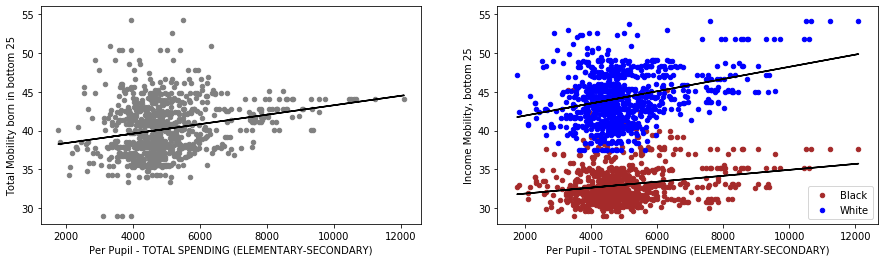

In [123]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,4), ncols=2,nrows=1)

x= 'Per Pupil - TOTAL SPENDING (ELEMENTARY-SECONDARY)'
ys = ['Black Mobility born in bottom 25','White Mobility born in bottom 25']

# screen out 0
adf=adf[adf[x]>0]

adf.plot(kind='scatter', x=x, y='Total Mobility born in bottom 25', color='grey', ax=ax1)  
ax1.set_ylim(28,56);


adf.plot(kind='scatter', x=x, y=ys[0], color='brown', ax=ax2)    
adf.plot(kind='scatter', x=x, y=ys[1], color='blue', ax=ax2)    
ax2.set_ylabel('Income Mobility, bottom 25');
ax2.set_ylim(28,56);
plt.legend(['Black', 'White']);

x= adf[x]
y = adf['Total Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('total Rsq: ', linearfit.rsquared)

y = adf[ys[0]]
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax2.plot(x, linearfit.fittedvalues, 'k-');
print('black Rsq: ' ,linearfit.rsquared)

y = adf[ys[1]]
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax2.plot(x, linearfit.fittedvalues, 'k-');
print('white Rsq: ', linearfit.rsquared)

black slope and Rsq:  0.00046 0.03
white slope and Rsq:  0.00104 0.08


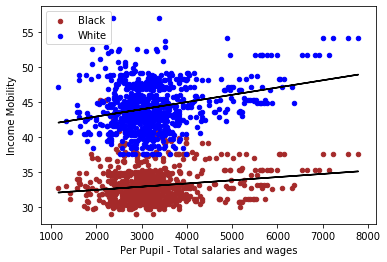

In [124]:
ax1 = adf.plot(kind='scatter', 
               x= 'Per Pupil - Total salaries and wages', 
               y='Black Mobility born in bottom 25', 
               color='brown')    
ax2 = adf.plot(kind='scatter', 
               x= 'Per Pupil - Total salaries and wages', 
               y='White Mobility born in bottom 25', 
               color='blue', ax=ax1)    
ax1.set_ylabel('Income Mobility');
plt.legend(['Black', 'White']);

x= adf['Per Pupil - Total salaries and wages']
y = adf['Black Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('black slope and Rsq: ' ,round(linearfit.params[1],5), round(linearfit.rsquared,2))
y = adf['White Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('white slope and Rsq: ' , round(linearfit.params[1],5), round(linearfit.rsquared,2))


black slope and Rsq:  0.00065 0.05
white slope and Rsq:  0.00129 0.11


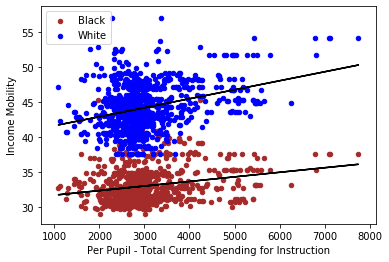

In [125]:
x = 'Per Pupil - Total Current Spending for Instruction'
ax1 = adf.plot(kind='scatter', x= x, y='Black Mobility born in bottom 25', color='brown')    
ax2 = adf.plot(kind='scatter', x= x, y='White Mobility born in bottom 25', color='blue', ax=ax1)    
ax1.set_ylabel('Income Mobility');
plt.legend(['Black', 'White']);

x= adf[x]
y = adf['Black Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('black slope and Rsq: ' ,round(linearfit.params[1],5), round(linearfit.rsquared,2))
y = adf['White Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('white slope and Rsq: ' , round(linearfit.params[1],5), round(linearfit.rsquared,2))



black slope and Rsq:  0.00373 0.03
white slope and Rsq:  0.01082 0.12


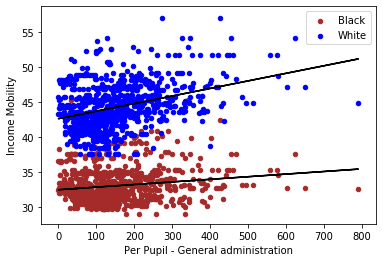

In [126]:
x = 'Per Pupil - General administration'
ax1 = adf.plot(kind='scatter', x= x, y='Black Mobility born in bottom 25', color='brown')    
adf.plot(kind='scatter', x= x, y='White Mobility born in bottom 25', color='blue', ax=ax1)    
ax1.set_ylabel('Income Mobility');
plt.legend(['Black', 'White']);


# Fits

x= adf[x]
y = adf['Black Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('black slope and Rsq: ' ,round(linearfit.params[1],5), round(linearfit.rsquared,2))
y = adf['White Mobility born in bottom 25']
linearfit = sm.OLS(y,sm.add_constant(x)).fit()
ax1.plot(x, linearfit.fittedvalues, 'k-');
print('white slope and Rsq: ' , round(linearfit.params[1],5), round(linearfit.rsquared,2))


### The above plots indicate that both the baseline income mobility and the increase in mobility due to education spending are higher for white students than for black students.

### Students born to parents at 75% income level

slope and Rsq:  1e-05 0.0
slope and Rsq:  0.0006 0.1
slope and Rsq:  0.00055 0.05
slope and Rsq:  0.00125 0.29


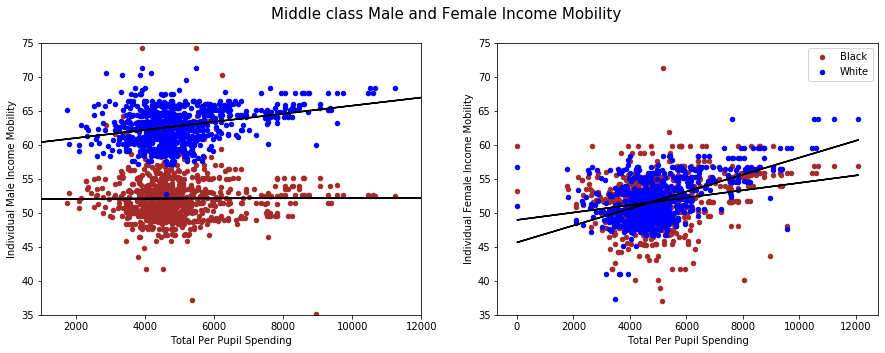

In [129]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2,nrows=1)
fig.suptitle('Middle class Male and Female Income Mobility',
            fontsize=15)

x= 'PPCSTOT'
ys = ['kir_black_male_p75', 'kir_white_male_p75',
      'kir_black_female_p75', 'kir_white_female_p75']

ddf.plot(kind='scatter', x=x, y=ys[0], color='brown', ax=ax1)    
ddf.plot(kind='scatter', x=x, y=ys[1], color='blue', ax=ax1)  
ax1.set_ylabel('Individual Male Income Mobility');
ax1.set_xlabel('Total Per Pupil Spending');
plt.legend(['Black', 'White']);
ax1.set_ylim(35,75);
ax1.set_xlim(1000,12000)

ddf.plot(kind='scatter', x=x, y=ys[2], color='brown', ax=ax2)    
ddf.plot(kind='scatter', x=x, y=ys[3], color='blue', ax=ax2)    
ax2.set_ylabel('Individual Female Income Mobility');
ax2.set_xlabel('Total Per Pupil Spending');
ax2.set_ylim(35,75);
plt.legend(['Black', 'White']);


# Fits

x= ddf[x]
axs = [ax1,ax1,ax2,ax2]
for (ax,y) in zip(axs,ys):
    y = ddf[y]
    linearfit = sm.OLS(y,sm.add_constant(x)).fit()
    ax.plot(x, linearfit.fittedvalues, 'k-');
    print('slope and Rsq: ' ,round(linearfit.params[1],5), round(linearfit.rsquared,2))


slope and Rsq:  0.01171 0.0
slope and Rsq:  0.06476 0.16
slope and Rsq:  0.07178 0.11
slope and Rsq:  0.11099 0.32


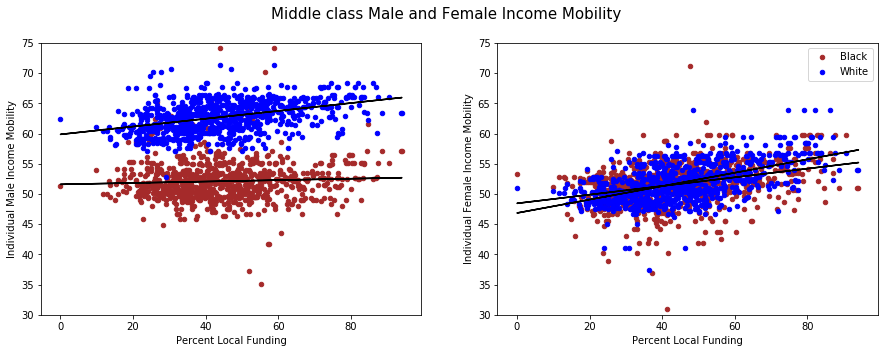

In [131]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2,nrows=1)
fig.suptitle('Middle class Male and Female Income Mobility',
            fontsize=15)

x= 'PCTLTOT'
ys = ['kir_black_male_p75', 'kir_white_male_p75','kir_black_female_p75','kir_white_female_p75']
ddf.plot(kind='scatter', x=x, y=ys[0], color='brown', ax=ax1)    
ddf.plot(kind='scatter', x=x, y=ys[1], color='blue', ax=ax1)  
ax1.set_ylabel('Individual Male Income Mobility');
ax1.set_xlabel('Percent Local Funding');
plt.legend(['Black', 'White']);
ax1.set_ylim(30,75);

ddf.plot(kind='scatter', x=x, y=ys[2], color='brown', ax=ax2)    
ddf.plot(kind='scatter', x=x, y=ys[3], color='blue', ax=ax2)    
ax2.set_ylabel('Individual Female Income Mobility');
ax2.set_xlabel('Percent Local Funding');
ax2.set_ylim(30,75);
plt.legend(['Black', 'White']);


# Fits
x= ddf[x]
axs = [ax1,ax1,ax2,ax2]
for (ax,y) in zip(axs,ys):
    y = ddf[y]
    linearfit = sm.OLS(y,sm.add_constant(x)).fit()
    ax.plot(x, linearfit.fittedvalues, 'k-');
    print('slope and Rsq: ' ,round(linearfit.params[1],5), round(linearfit.rsquared,2))


# Linear Regression using all education params

1) How well can we use the education funding dataset to predict student outcomes as measured by income mobility?


In [139]:
ys = ['kfr_pooled_p25', 'kfr_black_pooled_p25','kfr_white_pooled_p25', 
      
      'kir_black_female_p25', 'kir_black_female_p75', 
      'kir_black_male_p25', 'kir_black_male_p75', 
      
      'kir_hisp_female_p25','kir_hisp_female_p75', 
      'kir_hisp_male_p25', 'kir_hisp_male_p75',
      
      'kir_white_female_p25', 'kir_white_female_p75', 
      'kir_white_male_p25', 'kir_white_male_p75'
     ]

In [169]:
Xvars = [
    'cz_pop2000', 
    'cz_pop_black2000', 'cz_pop_hisp2000',
    'cz_pop_white2000',
#     'County Population 2000',
#     'ENROLL', 'TOTALREV', 
    
#     'TFEDREV', 'FEDRCOMP', 'FEDRHAND', 'FEDRNUTR', 'FEDROTHR', 
#     'TSTREV', 'STRFORM', 'STRHAND', 'STRTRANS', 'STROTHR', 
#     'TLOCREV', 'LOCRTAX', 'LOCRPROP', 'LOCRPAR', 'LOCRCICO', 'LOCROSCH', 'LOCRCHAR', 'LOCROTHR', 
#     'TOTALEXP', 'TCURELSC', 'TSALWAGE', 'TEMPBENE', 'TCURINST', 
#     'TCURISAL', 'TCURIBEN', 'TCURSSVC', 'TCURSPUP',
#     'TCURSSTA', 'TCURSGEN', 'TCURSSCH', 'TCURSOTH', 'TCURONON', 'TCAPOUT',
#     'TPAYOTH', 'TINTRST', 'DEBTOUT', 'LONGISSU', 'LONGRET', 
    'PCTTOTAL',
    'PCTFTOT', 
#     'PCTFCOMP', 
    'PCTSTOT', 
#     'PCTSFORM', 
    'PCTLTOT', 
#     'PCTLTAXP', 'PCTLOTHG', 'PCTLCHAR', 
    'PPCSTOT', 
#     'PPSALWG', 'PPEMPBEN', 
    'PPITOTAL', 
#     'PPISALWG',  'PPIEMBEN', 
    'PPSTOTAL', 
    'PPSPUPIL', 'PPSSTAFF', 'PPSGENAD',
#     'PPSSCHAD'
    ]

In [170]:
params = []
rsq = []
X = ddf[Xvars]
X = sm.add_constant(X)

for y in ys:
    olsmodel = sm.OLS(ddf[y], X).fit(cov_type = 'HC3') 
    predictions = olsmodel.predict(X)
#     print(olsmodel.summary())
    params.append(olsmodel.params)
    rsq.append(olsmodel.rsquared)

In [171]:
paramsdf = pd.DataFrame(params)
paramsdf['ys']=ys
paramsdf['rsq']=rsq
paramsdf.index=paramsdf.ys

In [172]:
paramsdf

,const,cz_pop2000,cz_pop_black2000,cz_pop_hisp2000,cz_pop_white2000,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,PPCSTOT,PPITOTAL,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,ys,rsq
ys,,,,,,,,,,,,,,,,,
kfr_pooled_p25,55.496704,0.000009,-0.000013,-0.000010,-0.000009,2.579621,-2.793085,-2.768522,-2.720763,-0.003144,0.004060,0.003783,-0.006206,-0.005886,0.006974,kfr_pooled_p25,0.393526
kfr_black_pooled_p25,39.048616,0.000005,-0.000005,-0.000006,-0.000005,-0.056904,0.085926,-0.044583,0.000435,-0.000257,0.000976,-0.000038,-0.000710,-0.001859,0.002318,kfr_black_pooled_p25,0.169602
kfr_white_pooled_p25,65.342647,0.000005,-0.000005,-0.000006,-0.000005,0.673622,-0.822569,-0.937556,-0.876800,-0.001820,0.002519,0.001833,-0.002041,-0.006324,0.008011,kfr_white_pooled_p25,0.390768
kir_black_female_p25,41.483833,0.000004,-0.000004,-0.000005,-0.000004,-0.286337,0.326522,0.236915,0.281903,-0.000880,0.001150,0.000837,0.001971,-0.001222,0.001839,kir_black_female_p25,0.363915
kir_black_female_p75,60.489215,0.000004,-0.000002,-0.000005,-0.000003,-5.579864,5.532408,5.450763,5.502618,0.000248,0.000133,-0.001528,0.004294,0.002640,-0.000320,kir_black_female_p75,0.237870
kir_black_male_p25,51.904553,0.000005,-0.000005,-0.000006,-0.000006,-1.678099,1.667973,1.503620,1.553932,0.004058,-0.003422,-0.005541,0.001886,-0.000851,0.003425,kir_black_male_p25,0.123060
kir_black_male_p75,74.689921,0.000004,-0.000004,-0.000005,-0.000005,1.041214,-1.187903,-1.300435,-1.254801,0.003843,-0.002682,-0.006486,0.003223,-0.000326,0.003627,kir_black_male_p75,0.104900
kir_hisp_female_p25,40.350229,0.000008,-0.000005,-0.000010,-0.000009,-1.546059,1.508691,1.496306,1.552217,-0.001722,0.001154,0.003714,0.000536,0.000348,-0.001095,kir_hisp_female_p25,0.471820
kir_hisp_female_p75,48.496604,0.000003,-0.000001,-0.000004,-0.000003,-3.613588,3.670055,3.575933,3.623465,-0.002214,0.002361,0.003825,-0.002795,-0.000645,-0.000162,kir_hisp_female_p75,0.343832


In [177]:
(paramsdf[['const',
#     'PCTTOTAL','PCTLTOT', 'PCTLTAXP', 
#     'PCTFTOT', 'PCTFCOMP', 
#     'PCTSTOT', 'PCTSFORM', 
#     'PCTLTOT', 'PCTLTAXP', 'PCTLOTHG', 'PCTLCHAR', 
    'PPCSTOT', 
#            'PPSALWG',
    'PPITOTAL',
    'rsq']]
 .sort_values(by=['const'], ascending=False)
 .style.bar(subset=["PPCSTOT",'PPITOTAL'], color='lightgreen',align='mid')
)

,const,PPCSTOT,PPITOTAL,rsq
ys,,,,
kir_white_male_p75,80.281060,-0.000742,0.001405,0.351964
kir_hisp_male_p75,77.116391,-0.000084,-0.000159,0.144954
kir_black_male_p75,74.689921,0.003843,-0.002682,0.104900
kir_white_male_p25,73.190594,-0.000631,0.001022,0.318722
kir_hisp_male_p25,71.692227,0.002778,-0.003485,0.232567
kfr_white_pooled_p25,65.342647,-0.001820,0.002519,0.390768
kir_black_female_p75,60.489215,0.000248,0.000133,0.237870
kfr_pooled_p25,55.496704,-0.003144,0.004060,0.393526
kir_white_female_p75,53.156607,-0.004980,0.006448,0.567236


In [174]:
paramsdf.PCTLTOT.sort_values(ascending=False)

ys
kir_black_female_p75    5.502618
kir_white_female_p75    3.758423
kir_hisp_female_p75     3.623465
kir_white_female_p25    2.224184
kir_black_male_p25      1.553932
kir_hisp_female_p25     1.552217
kir_hisp_male_p25       1.275610
kir_black_female_p25    0.281903
kfr_black_pooled_p25    0.000435
kir_white_male_p75     -0.468506
kfr_white_pooled_p25   -0.876800
kir_hisp_male_p75      -1.074064
kir_black_male_p75     -1.254801
kir_white_male_p25     -1.444382
kfr_pooled_p25         -2.720763
Name: PCTLTOT, dtype: float64

In [175]:
paramsdf.PPITOTAL.sort_values(ascending=False)

ys
kir_white_female_p75    0.006448
kir_white_female_p25    0.005869
kfr_pooled_p25          0.004060
kfr_white_pooled_p25    0.002519
kir_hisp_female_p75     0.002361
kir_white_male_p75      0.001405
kir_hisp_female_p25     0.001154
kir_black_female_p25    0.001150
kir_white_male_p25      0.001022
kfr_black_pooled_p25    0.000976
kir_black_female_p75    0.000133
kir_hisp_male_p75      -0.000159
kir_black_male_p75     -0.002682
kir_black_male_p25     -0.003422
kir_hisp_male_p25      -0.003485
Name: PPITOTAL, dtype: float64